## DATA 422 Group Project - Josie (jst218)
### Animate a gif from the Earthquake data


This notebook creates two separate dataframes: 'regions' and 'quakes'.
Regions is used to plot a map of New Zealand with regional boundaries.
Quakes is used to plot earthquakes using lat-long coordinates, on the NZ map

In [1]:
# Libraries

library(tidyverse)
library(sf)
library(glue)
library(geojsonio)
library(dplyr)
library(rgeos)
library(sp)
library(rgdal)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.5
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Linking to GEOS 3.7.2, GDAL 2.4.2, PROJ 5.2.0; sf_use_s2() is TRUE

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson


Attaching package: ‘geojsonio’


The following object is masked from ‘package:base’:

    pretty


Loading required package: sp

rgeos version: 0.5-9, (SVN revision 684)
 GEOS runtime version: 3.7.2-CAPI-1.11.2 
 Please note that rgeos will be retired by the end of 2023,
plan transition to sf functions using GEOS at your earliest convenience.
 Linking to sp version: 1.4-6 
 Polygon checking: TRUE 


Please note that rgdal will be retired by the e

## URLs for earthquakes downloads

- https://quakesearch.geonet.org.nz/csv?bbox=163.5205,-49.1817,-176.9238,-32.2871&startdate=2017-03-01&enddate=2017-12-31T7:00:00
- https://quakesearch.geonet.org.nz/csv?bbox=163.5205,-49.1817,-176.9238,-32.2871&startdate=2016-11-01&enddate=2017-03-01
- https://quakesearch.geonet.org.nz/csv?bbox=163.5205,-49.1817,-176.9238,-32.2871&startdate=2015-11-01&enddate=2016-11-01
- https://quakesearch.geonet.org.nz/csv?bbox=163.5205,-49.1817,-176.9238,-32.2871&startdate=2014-11-01&enddate=2015-11-01
- https://quakesearch.geonet.org.nz/csv?bbox=163.5205,-49.1817,-176.9238,-32.2871&startdate=2014-01-01T7:00:00&enddate=2014-11-01

In [2]:
# Read in each of the csv's (there is a 20,000 row limit on the exports from geonet Quake Search)

earthquake1 <- read.csv("https://quakesearch.geonet.org.nz/csv?bbox=163.5205,-49.1817,-176.9238,-32.2871&startdate=2017-03-01&enddate=2017-12-31T7:00:00")
earthquake2 <- read.csv("https://quakesearch.geonet.org.nz/csv?bbox=163.5205,-49.1817,-176.9238,-32.2871&startdate=2016-11-01&enddate=2017-03-01")
earthquake3 <- read.csv("https://quakesearch.geonet.org.nz/csv?bbox=163.5205,-49.1817,-176.9238,-32.2871&startdate=2015-11-01&enddate=2016-11-01")
earthquake4 <- read.csv("https://quakesearch.geonet.org.nz/csv?bbox=163.5205,-49.1817,-176.9238,-32.2871&startdate=2014-11-01&enddate=2015-11-01")
earthquake5 <- read.csv("https://quakesearch.geonet.org.nz/csv?bbox=163.5205,-49.1817,-176.9238,-32.2871&startdate=2014-01-01T7:00:00&enddate=2014-11-01")
  
# Row bind the csv's into one dataframe
quakes <- do.call("rbind", list(earthquake1, earthquake2, earthquake3, earthquake4,earthquake5))


In [3]:
head(quakes)

,publicid,eventtype,origintime,modificationtime,longitude,latitude,magnitude,depth,magnitudetype,depthtype,⋯,evaluationstatus,evaluationmode,earthmodel,usedphasecount,usedstationcount,magnitudestationcount,minimumdistance,azimuthalgap,originerror,magnitudeuncertainty
,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,2017p984556,,2017-12-31T06:51:30.034Z,2017-12-31T06:53:28.344Z,175.0064,-41.39838,1.581007,21.640625,M,,⋯,,automatic,nz3drx,11,11,7,0.10245887,130.07508,0.1787867,0
2,2017p984528,,2017-12-31T06:37:56.519Z,2017-12-31T06:41:02.657Z,175.9204,-38.87388,2.193771,159.687500,M,,⋯,,automatic,nz3drx,37,37,18,0.35726708,189.89333,1.6659082,0
3,2017p984480,,2017-12-31T06:11:04.004Z,2017-12-31T06:12:38.146Z,175.8808,-40.61563,1.588915,25.390625,M,,⋯,,automatic,nz3drx,14,14,8,0.09205309,81.91769,0.2982634,0
4,2017p984181,,2017-12-31T03:31:52.604Z,2017-12-31T03:34:17.625Z,176.0742,-39.27950,2.179969,46.484375,M,,⋯,,automatic,nz3drx,55,55,36,0.21035583,45.83764,0.5727317,0
5,2017p984157,,2017-12-31T03:19:38.237Z,2017-12-31T03:21:40.391Z,177.0645,-39.55705,1.847687,20.468750,M,,⋯,,automatic,nz3drx,12,12,6,0.28505316,195.40885,0.3182329,0
6,2017p984059,,2017-12-31T02:26:53.331Z,2017-12-31T02:28:37.743Z,174.3273,-41.68864,2.106633,9.921875,M,,⋯,,automatic,nz3drx,19,19,8,0.10563158,138.80680,0.4924095,0


## Import shapefile of regional council areas
https://koordinates.com/from/datafinder.stats.govt.nz/layer/106666/download/

Note: Must set the projection to WGS 84

In [4]:
# Important - all other files that come with the .shp file (in the zip download) 
# must be in the same folder as you are calling the .shp file from
# Unzip the download folder and then take all contents to directory you are calling from

regions <- st_read("regional-council-2022-generalised.shp") %>%
           st_transform(crs = 4326)

Reading layer `regional-council-2022-generalised' from data source 
  `/Users/josiestockill/Documents/DATA422-Group/regional-council-2022-generalised.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 17 features and 6 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -177.3579 ymin: -47.72405 xmax: 178.8362 ymax: -33.9585
CRS:           4326


### Plot an animated map

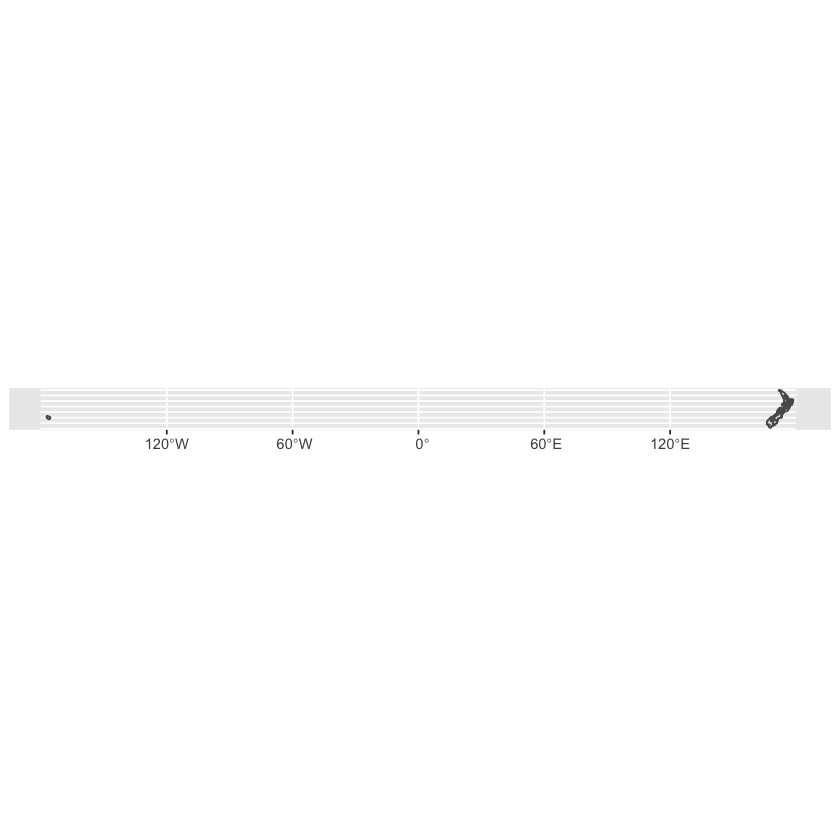

In [20]:
# Transform regional data with sf package

regions2 <- regions %>% filter(REGC2022_2!="NA")
ggplot(regions2) + 
  geom_sf() + 
  coord_sf()

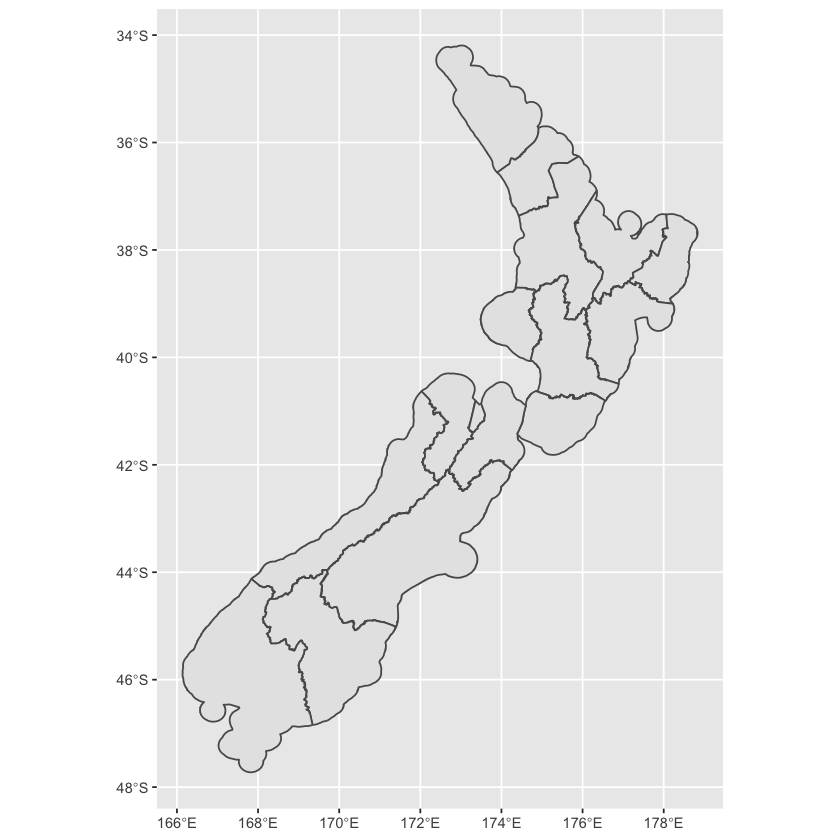

In [21]:
# Need to remove chathams (?)

regions3 <- regions %>% filter(REGC2022_2!="Area Outside Region")
ggplot(regions3) + 
  geom_sf() + 
  coord_sf()

In [22]:
# Add year column to quakes
quakes_mappoints <- quakes 
quakes_mappoints$year = as.numeric(substr(quakes_mappoints$origintime, 1, 4))
#head(quakes_mappoints)
unique(quakes_mappoints$year)


[1] 2017 2016 2015 2014

In [23]:
head(reg_quakes)

,publicid,origintime,magnitude,depth,REGC2022_2,REGC2022_V,year
,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
1,2017p984556,2017-12-31T06:51:30.034Z,1.581007,21.640625,Wellington Region,09,2017
2,2017p984528,2017-12-31T06:37:56.519Z,2.193771,159.687500,Waikato Region,03,2017
3,2017p984480,2017-12-31T06:11:04.004Z,1.588915,25.390625,Manawatu-Whanganui Region,08,2017
4,2017p984181,2017-12-31T03:31:52.604Z,2.179969,46.484375,Manawatu-Whanganui Region,08,2017
5,2017p984157,2017-12-31T03:19:38.237Z,1.847687,20.468750,Hawke's Bay Region,06,2017
6,2017p984059,2017-12-31T02:26:53.331Z,2.106633,9.921875,Marlborough Region,18,2017


In [24]:
unique(reg_quakes$REGC2022_2)

[1] Wellington Region         Waikato Region           
 [3] Manawatu-Whanganui Region Hawke's Bay Region       
 [5] Marlborough Region        West Coast Region        
 [7] Canterbury Region         Bay of Plenty Region     
 [9] <NA>                      Gisborne Region          
[11] Otago Region              Southland Region         
[13] Taranaki Region           Tasman Region            
[15] Nelson Region             Auckland Region          
[17] Northland Region         
17 Levels: Area Outside Region Auckland Region ... West Coast Region

In [25]:
# Remove quakes outside region

# get list of IDs of quakes outside region
list_df <- reg_quakes %>% select(publicid, REGC2022_2) %>%
          filter(is.na(REGC2022_2))
#head(list_df)

quakes_mappoints2 <- anti_join(quakes_mappoints, list_df, by="publicid")
head(quakes_mappoints2)

,publicid,eventtype,origintime,modificationtime,longitude,latitude,magnitude,depth,magnitudetype,depthtype,⋯,evaluationmode,earthmodel,usedphasecount,usedstationcount,magnitudestationcount,minimumdistance,azimuthalgap,originerror,magnitudeuncertainty,year
,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,⋯,<fct>,<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2017p984556,,2017-12-31T06:51:30.034Z,2017-12-31T06:53:28.344Z,175.0064,-41.39838,1.581007,21.640625,M,,⋯,automatic,nz3drx,11,11,7,0.10245887,130.07508,0.1787867,0,2017
2,2017p984528,,2017-12-31T06:37:56.519Z,2017-12-31T06:41:02.657Z,175.9204,-38.87388,2.193771,159.687500,M,,⋯,automatic,nz3drx,37,37,18,0.35726708,189.89333,1.6659082,0,2017
3,2017p984480,,2017-12-31T06:11:04.004Z,2017-12-31T06:12:38.146Z,175.8808,-40.61563,1.588915,25.390625,M,,⋯,automatic,nz3drx,14,14,8,0.09205309,81.91769,0.2982634,0,2017
4,2017p984181,,2017-12-31T03:31:52.604Z,2017-12-31T03:34:17.625Z,176.0742,-39.27950,2.179969,46.484375,M,,⋯,automatic,nz3drx,55,55,36,0.21035583,45.83764,0.5727317,0,2017
5,2017p984157,,2017-12-31T03:19:38.237Z,2017-12-31T03:21:40.391Z,177.0645,-39.55705,1.847687,20.468750,M,,⋯,automatic,nz3drx,12,12,6,0.28505316,195.40885,0.3182329,0,2017
6,2017p984059,,2017-12-31T02:26:53.331Z,2017-12-31T02:28:37.743Z,174.3273,-41.68864,2.106633,9.921875,M,,⋯,automatic,nz3drx,19,19,8,0.10563158,138.80680,0.4924095,0,2017


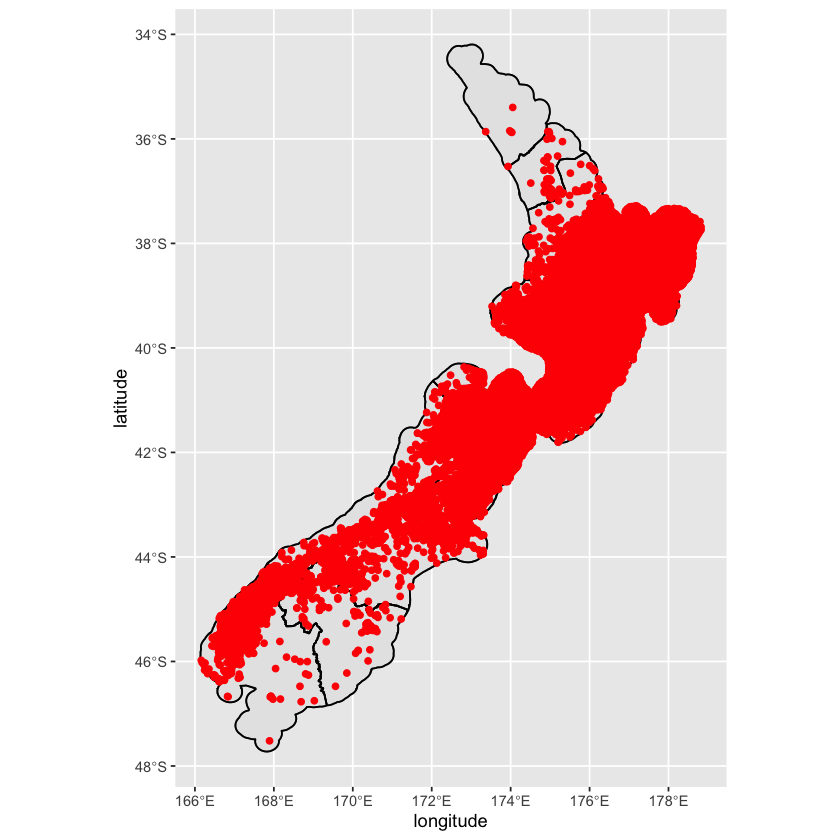

In [26]:
# Plot quakes

allquakes <- ggplot() + 
  geom_sf(data = regions3) + 
  geom_sf(data = regions3, colour = "black", fill = NA) + 
  geom_point(data = quakes_mappoints2, mapping = aes(x = longitude, y = latitude), colour = "red") + 
  coord_sf()
allquakes

In [ ]:
# Save as png

ggsave(plot=allquakes, filename="allquakesNZ2014-2017.png", width=7, height=9)

In [ ]:
# Library required for animation
library(gganimate)

In [ ]:
# Animate the plot from above
ggplot() + 
  geom_sf(data = regions3) + 
  geom_sf(data = regions3, colour = "black", fill = NA) + 
  geom_point(data = quakes_mappoints2, mapping = aes(x = longitude, y = latitude), colour = "red", size=magnitude) + 
  coord_sf() +
  transition_reveal(as.Date(origintime))

In [ ]:
# Animate a new plot
# - Points coded with size and colour representing magntiude
# - Save to a gif
animateplot2 <- ggplot() + 
  geom_sf(data = regions3) + 
  geom_sf(data = regions3, colour = "black", fill = NA) + 
  geom_point(data = quakes_mappoints2, 
             mapping = aes(name="Magnitude", 
                           x = longitude, y = latitude, 
                           colour = abs(quakes_mappoints2$magnitude)), 
             size=(quakes_mappoints2$magnitude*10)) + 
  labs(colour = "Magnitude") +
  scale_fill_viridis_c(name="Magnitude", option = "magma") +
  coord_sf() +
  transition_reveal(as.Date(origintime))

# Save to gif
animate(animateplot2, renderer = gifski_renderer())
anim_save("earthquakes2014to2016.gif")

In [ ]:
# Stagnant graph of the animated graph above
animateplot2 <- ggplot() + 
  geom_sf(data = regions3) + 
  geom_sf(data = regions3, colour = "black", fill = NA) + 
  geom_point(data = quakes_mappoints2, mapping = aes(name="Magnitude", x = longitude, y = latitude, colour = abs(quakes_mappoints2$magnitude)), 
             size=(quakes_mappoints2$magnitude*10)) + 
  labs(colour = "Magnitude") +
  scale_fill_viridis_c(name="Magnitude", option = "magma") +
  coord_sf() +
  transition_reveal(as.Date(origintime))
animateplot2

In [ ]:
head(quakes_mappoints2)

In [ ]:
# Reduce number of quakes - only over 4.0 magnitude

quakes_over4 <- quakes_mappoints2 %>%
      filter(magnitude > 4.0)

# Add info column
quakes_over4$tooltip <- c(paste0("Year = ", quakes_over4$year, 
                                 "\n Magnitude = ", quakes_over4$magnitude))


In [ ]:
# This library staggers points or labels on a graph
library(ggrepel)

In [ ]:

quakes_over4$magnitude <- round(quakes_over4$magnitude, 2)
head(quakes_over4)

In [ ]:
# Test adding labels
animateplot3 <- ggplot() + 
  geom_sf(data = regions3) + 
  geom_sf(data = regions3, colour = "black", fill = NA) + 
  geom_point(data = quakes_over4, 
             mapping = aes(x = longitude, y = latitude, 
                           colour = abs(quakes_over4$magnitude)), 
             size=(quakes_over4$magnitude*10)) + 
  labs(colour = "Magnitude") +
  scale_fill_viridis_c(name="Magnitude", option = "magma") +
  coord_sf() +
  transition_reveal(as.Date(origintime)) +
  geom_label_repel(data = quakes_over4,
      aes(x = longitude, y = latitude, label = quakes_over4$tooltip),
                  box.padding   = 0.35, 
                  point.padding = 0.5,
                  segment.color = 'grey50')
animateplot3

In [ ]:
# Filter out earthquakes & slow down animation

# Save to gif
animate(animateplot3, renderer = gifski_renderer(), fps=1.5)
anim_save("earthquakes2014to2016_overmag4.gif")

In [ ]:
# one last attempt - smaller dots and slower speed
animateplot4 <- ggplot() + 
  geom_sf(data = regions3) + 
  geom_sf(data = regions3, colour = "black", fill = NA) + 
  geom_point(data = quakes_over4, 
             mapping = aes(x = longitude, y = latitude, 
                           colour = abs(quakes_over4$magnitude)), 
             size=(quakes_over4$magnitude)) + 
  labs(colour = "Magnitude") +
  scale_fill_viridis_c(name="Magnitude", option = "magma") +
  coord_sf() +
  transition_reveal(as.Date(origintime)) +
  geom_label_repel(data = quakes_over4,
      aes(x = longitude, y = latitude, label = quakes_over4$tooltip),
                  box.padding   = 0.35, 
                  point.padding = 0.5,
                  segment.color = 'grey50')
animateplot4

# Save to gif
animate(animateplot4, renderer = gifski_renderer(), fps=0.8)
anim_save("earthquakes2014to2016_overmag4SLOW.gif")